## Data Loading

In [6]:
%pip install netCDF4 h5netcdf xarray pandas "numpy<2" matplotlib seaborn packaging scipy store statsmodels plotly nbformat pmdarima


You should consider upgrading via the '/usr/local/bin/python3.10 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [7]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Assuming your .nc file is named 'microplastic_data.nc'
ds = xr.open_dataset('/Users/autinauyeung/arima-mircoplastic/data/cyg.ddmi.s20180816-120000-e20180816-120000.l3.grid-microplastic.a32.d33.nc', engine='netcdf4')
ds = ds.to_dataframe().reset_index()
ds = ds.dropna()
ds

,lat,lon,time,num_mp_samples,stddev_mp_samples,mp_concentration
0,-37.0,0.00,2018-08-16 12:00:00,817.0,0.135344,12866.504883
1,-37.0,0.25,2018-08-16 12:00:00,814.0,0.130202,12746.297852
2,-37.0,0.50,2018-08-16 12:00:00,812.0,0.125060,12626.090820
3,-37.0,0.75,2018-08-16 12:00:00,810.0,0.119918,12505.883789
4,-37.0,1.00,2018-08-16 12:00:00,808.0,0.114776,12385.675781
...,...,...,...,...,...,...
427675,37.0,358.75,2018-08-16 12:00:00,378.0,0.164024,13963.895508
427676,37.0,359.00,2018-08-16 12:00:00,472.0,0.162074,14053.669922
427677,37.0,359.25,2018-08-16 12:00:00,522.0,0.162901,13929.945312
427678,37.0,359.50,2018-08-16 12:00:00,572.0,0.163729,13806.220703


## Data Processing

Single File Investigation 

Investigation Area: 
Latitutde: -30.5 and 17.25 
Longitutde: 72 and 215.25 

In [5]:
subset = ds.where(
    (ds['lat'] >= -30.5) & (ds['lat'] <= 17.25) &
    (ds['lon'] >= 72) & (ds['lon'] <= 215.25)).dropna()
subset

,lat,lon,time,num_mp_samples,stddev_mp_samples,mp_concentration
37728,-30.50,72.00,2018-08-16 12:00:00,923.0,0.183145,12876.937500
37729,-30.50,72.25,2018-08-16 12:00:00,913.0,0.183003,12908.672852
37730,-30.50,72.50,2018-08-16 12:00:00,903.0,0.182860,12940.408203
37731,-30.50,72.75,2018-08-16 12:00:00,893.0,0.182717,12972.144531
37732,-30.50,73.00,2018-08-16 12:00:00,884.0,0.182575,13003.879883
...,...,...,...,...,...,...
313337,17.25,214.25,2018-08-16 12:00:00,861.0,0.141743,12359.061523
313338,17.25,214.50,2018-08-16 12:00:00,832.0,0.142005,12329.065430
313339,17.25,214.75,2018-08-16 12:00:00,803.0,0.142266,12299.068359
313340,17.25,215.00,2018-08-16 12:00:00,774.0,0.142528,12269.072266


In [6]:
total_mp = subset['mp_concentration'].sum()
print(total_mp)

1245180000.0


In [7]:
lat_min, lat_max = -30.5, 17.25
lon_min, lon_max = 72, 215.25

# Area in degrees^2
area_deg2 = (lat_max - lat_min) * (lon_max - lon_min)

# Area in km^2 (approximate, using mean latitude)
mean_lat = (lat_min + lat_max) / 2
lat_km = 111 * (lat_max - lat_min)
lon_km = 111 * np.cos(np.deg2rad(mean_lat)) * (lon_max - lon_min)
area_km2 = lat_km * lon_km

print(area_km2)

83715185.88151443


In [8]:
avg_mp = total_mp / area_km2
print(avg_mp)

14.87400426682866


In [9]:
type(subset['time'])

pandas.core.series.Series

In [10]:
date = pd.to_datetime(subset['time'].values[0]).date()
print(date)

2018-08-16


Load more data

In [11]:
import os
from tqdm import tqdm


lat_min, lat_max = -30.5, 17.25
lon_min, lon_max = 72, 215.25

mean_lat = (lat_min + lat_max) / 2
lat_km = 111 * (lat_max - lat_min)
lon_km = 111 * np.cos(np.deg2rad(mean_lat)) * (lon_max - lon_min)
area_km2 = lat_km * lon_km

results = []

data_folder = 'data'

files = [file for file in os.listdir(data_folder)]


In [12]:
len(files)

2487

In [13]:
for file in tqdm(files, desc='Processing NetCDF files'):
    if file.endswith('.nc'):
        file_path=os.path.join(data_folder, file)
        ds = xr.open_dataset(file_path)
        ds = ds.to_dataframe().reset_index()
        ds = ds.dropna()

        subset = ds.where(
            (ds['lat'] >= lat_min) & (ds['lat'] <= lat_max) &
            (ds['lon'] >= lon_min) & (ds['lon'] <= lon_max)).dropna()

        total_mp = subset['mp_concentration'].sum()

        avg_mp = total_mp / area_km2

        date = pd.to_datetime(subset['time'].values[0]).date()

        results.append({'time': date, 'mp_concentration': avg_mp})

results 

Processing NetCDF files: 100%|██████████| 2487/2487 [05:52<00:00,  7.05it/s]


[{'time': datetime.date(2021, 11, 25),
  'mp_concentration': np.float64(14.547681823506794)},
 {'time': datetime.date(2021, 8, 24),
  'mp_concentration': np.float64(14.624168209251222)},
 {'time': datetime.date(2024, 12, 1),
  'mp_concentration': np.float64(14.55926089353803)},
 {'time': datetime.date(2024, 5, 13),
  'mp_concentration': np.float64(14.696244976882605)},
 {'time': datetime.date(2025, 2, 24),
  'mp_concentration': np.float64(14.605490021016495)},
 {'time': datetime.date(2020, 10, 31),
  'mp_concentration': np.float64(14.661264656775035)},
 {'time': datetime.date(2020, 9, 30),
  'mp_concentration': np.float64(14.600078911965849)},
 {'time': datetime.date(2018, 9, 28),
  'mp_concentration': np.float64(14.73309066942357)},
 {'time': datetime.date(2018, 10, 29),
  'mp_concentration': np.float64(14.742376248758008)},
 {'time': datetime.date(2020, 7, 23),
  'mp_concentration': np.float64(14.74343431246613)},
 {'time': datetime.date(2024, 3, 30),
  'mp_concentration': np.float64

In [19]:
df = pd.DataFrame(results)
df.to_csv("mp_conc_updated.csv", index=False)
df

,time,mp_concentration
0,2021-11-25,14.547682
1,2021-08-24,14.624168
2,2024-12-01,14.559261
3,2024-05-13,14.696245
4,2025-02-24,14.605490
...,...,...
2481,2021-11-05,14.534156
2482,2024-12-21,14.725126
2483,2021-06-17,14.638686
2484,2020-01-20,14.701612


In [23]:
df = pd.read_csv('mp_conc_updated.csv')
df = df.sort_values('time').reset_index().drop(columns=['index'])
df.to_csv("mp_conc_sorted.csv", index=False)
df

,time,mp_concentration
0,2018-08-16,14.874004
1,2018-08-17,14.868096
2,2018-08-18,14.865804
3,2018-08-19,14.854756
4,2018-08-20,14.843458
...,...,...
2481,2025-06-01,14.724918
2482,2025-06-02,14.717412
2483,2025-06-03,14.719857
2484,2025-06-04,14.722201


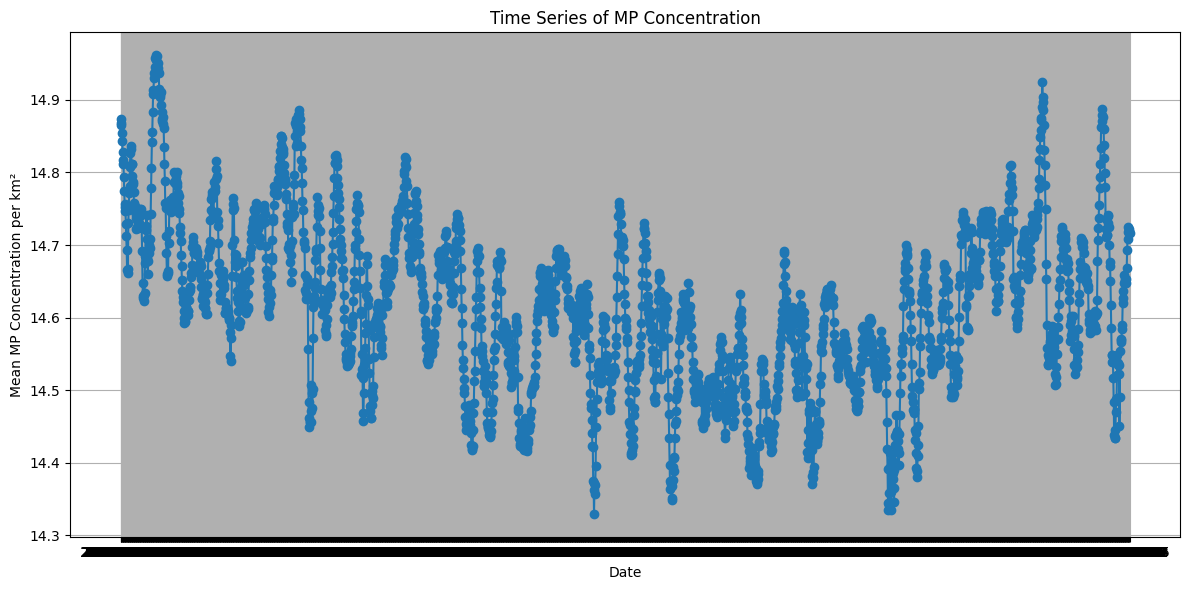

In [18]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['mp_concentration'], marker='o')
plt.xlabel('Date')
plt.ylabel('Mean MP Concentration per km²')
plt.title('Time Series of MP Concentration')
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
df = pd.read_csv('mp_conc_sorted.csv')
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time')
df

,mp_concentration
time,
2018-08-16,14.874004
2018-08-17,14.868096
2018-08-18,14.865804
2018-08-19,14.854756
2018-08-20,14.843458
...,...
2025-06-01,14.724918
2025-06-02,14.717412
2025-06-03,14.719857


In [35]:
weekly_df = df.resample('W').mean()
weekly_df.dropna()
weekly_df.to_csv('mp_conc_weekly.csv')
weekly_df

,mp_concentration
time,
2018-08-19,14.865665
2018-08-26,14.803406
2018-09-02,14.709439
2018-09-09,14.761217
2018-09-16,14.808359
...,...
2025-05-11,14.521454
2025-05-18,14.560788
2025-05-25,14.642275


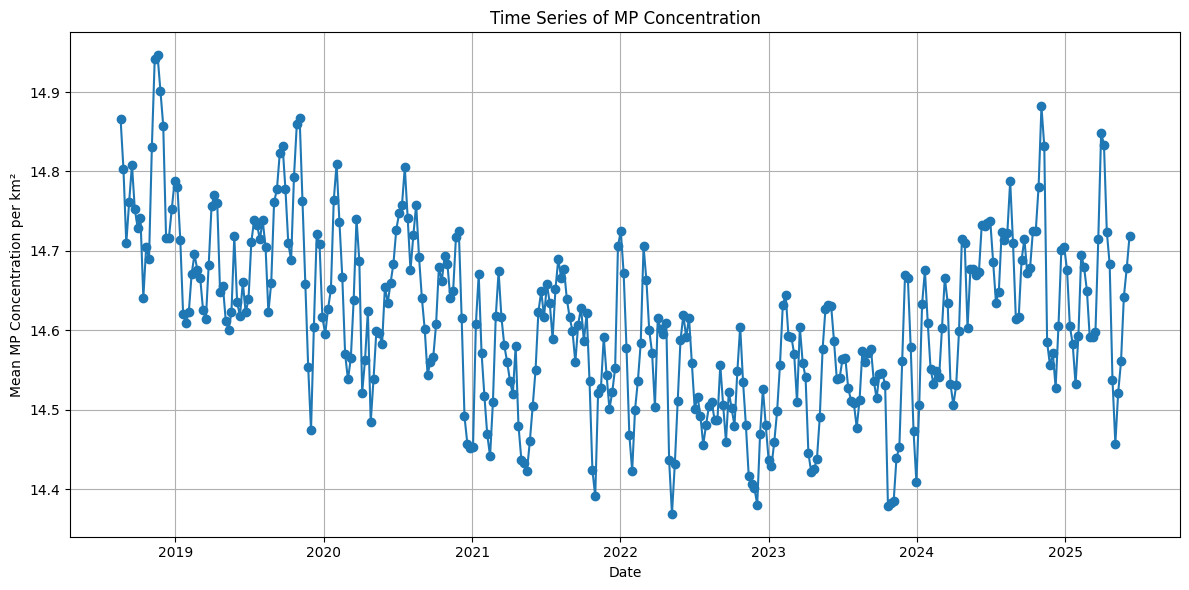

In [36]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(weekly_df.index, weekly_df['mp_concentration'], marker='o')
plt.xlabel('Date')
plt.ylabel('Mean MP Concentration per km²')
plt.title('Time Series of MP Concentration')
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
monthly_df = df.resample('M').mean()
monthly_df.dropna()
monthly_df.to_csv('mp_conc_monthly.csv')

/var/folders/j9/ndmp7tg95qjck81gbd4gdfy00000gn/T/ipykernel_21357/200660968.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = df.resample('M').mean()


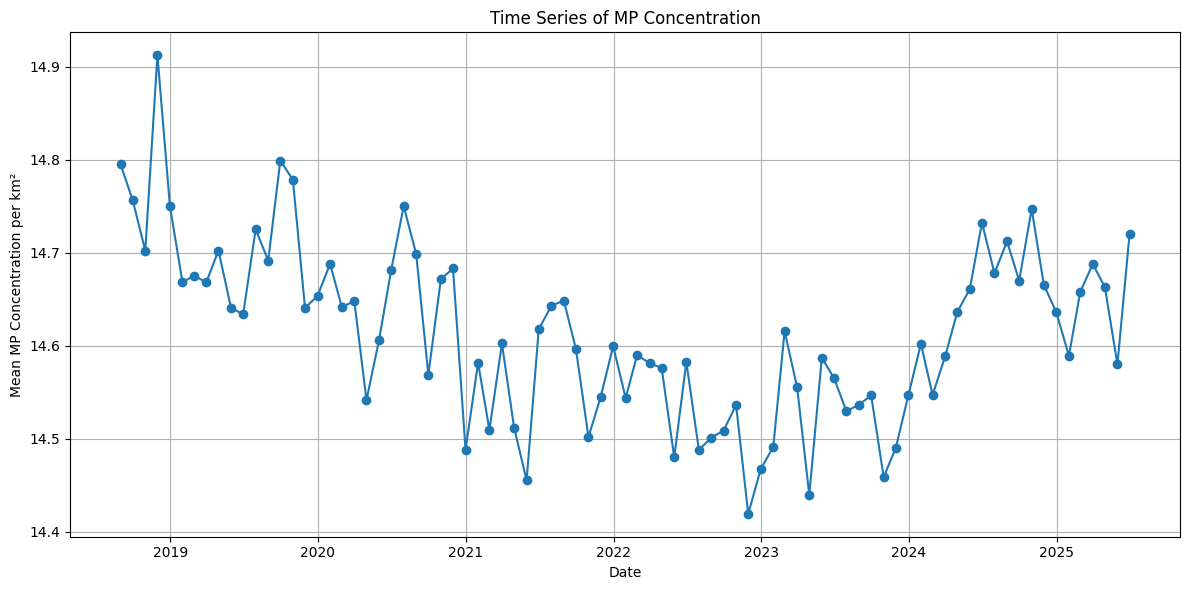

In [38]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(monthly_df.index, monthly_df['mp_concentration'], marker='o')
plt.xlabel('Date')
plt.ylabel('Mean MP Concentration per km²')
plt.title('Time Series of MP Concentration')
plt.grid(True)
plt.tight_layout()
plt.show()

## Stationarity 

In [5]:
data = pd.read_csv("mp_conc_monthly.csv")
data

,time,mp_concentration
0,2018-08-31,14.794952
1,2018-09-30,14.756403
2,2018-10-31,14.702092
3,2018-11-30,14.912478
4,2018-12-31,14.750171
...,...,...
78,2025-02-28,14.657710
79,2025-03-31,14.687917
80,2025-04-30,14.663004
81,2025-05-31,14.579799


In [23]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    test_results = adfuller(series)
    print("ADF Statistic: ", test_results[0])
    print("p-value: ", test_results[1])
    print("Critical values: ")
    for thres, adf_stat in test_results[4].items():
        print('\t%s: %.2f' % (thres, adf_stat))

adf_test(data['mp_concentration'][:])

ADF Statistic:  -2.765115693810824
p-value:  0.06343210249934468
Critical values: 
	1%: -3.52
	5%: -2.90
	10%: -2.59


In [24]:
def plot_graph(df: pd.DataFrame, y: str):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df[y], marker='o')
    plt.xlabel('Date')
    plt.ylabel('Mean MP Concentration per km²')
    plt.title('Time Series of '+ y)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [25]:
from scipy.stats import boxcox

data['mp_conc_boxcox'], lam = boxcox(data['mp_concentration'])
data['mp_conc_diff'] = data['mp_concentration'].diff()
data['mp_conc_log'] = np.log(data['mp_concentration'])
data['mp_conc_logndiff'] = data['mp_conc_log'].diff()
data

,mp_concentration,mp_conc_boxcox,mp_conc_diff,mp_conc_log,mp_conc_logndiff
time,,,,,
2018-08-31,14.794952,0.078685,NaN,2.694286,NaN
2018-09-30,14.756403,0.078685,-0.038549,2.691677,-0.002609
2018-10-31,14.702092,0.078685,-0.054311,2.687990,-0.003687
2018-11-30,14.912478,0.078685,0.210386,2.702198,0.014208
2018-12-31,14.750171,0.078685,-0.162306,2.691255,-0.010944
...,...,...,...,...,...
2025-02-28,14.657710,0.078685,0.068743,2.684966,0.004701
2025-03-31,14.687917,0.078685,0.030207,2.687025,0.002059
2025-04-30,14.663004,0.078685,-0.024913,2.685328,-0.001698


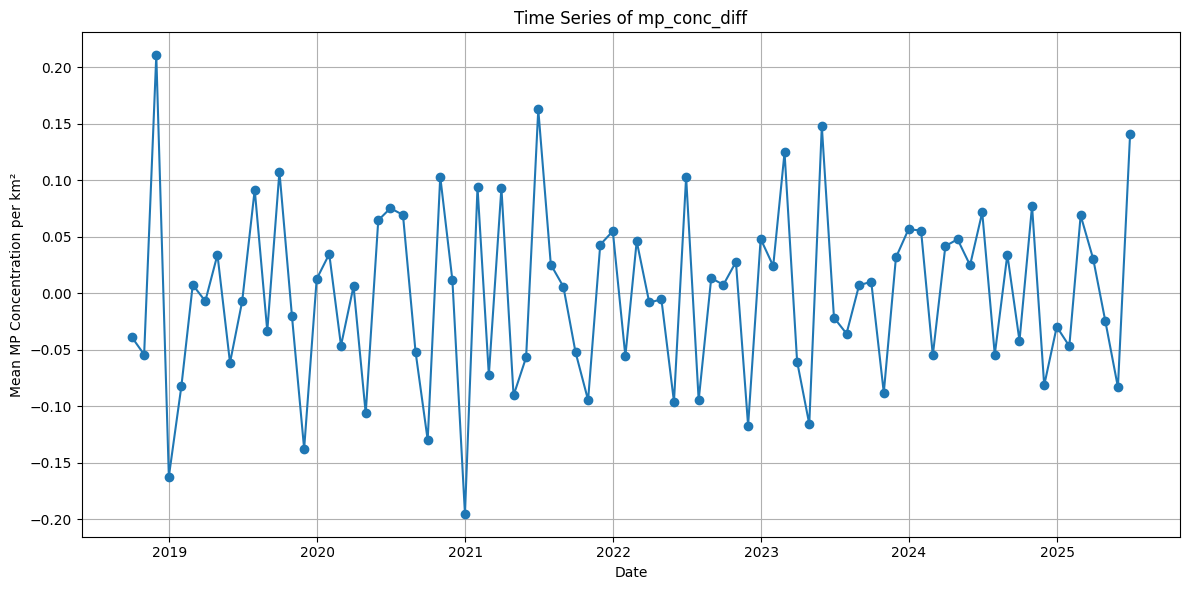

ADF Statistic:  -8.301514331936666
p-value:  4.006608636219424e-13
Critical values: 
	1%: -3.52
	5%: -2.90
	10%: -2.59


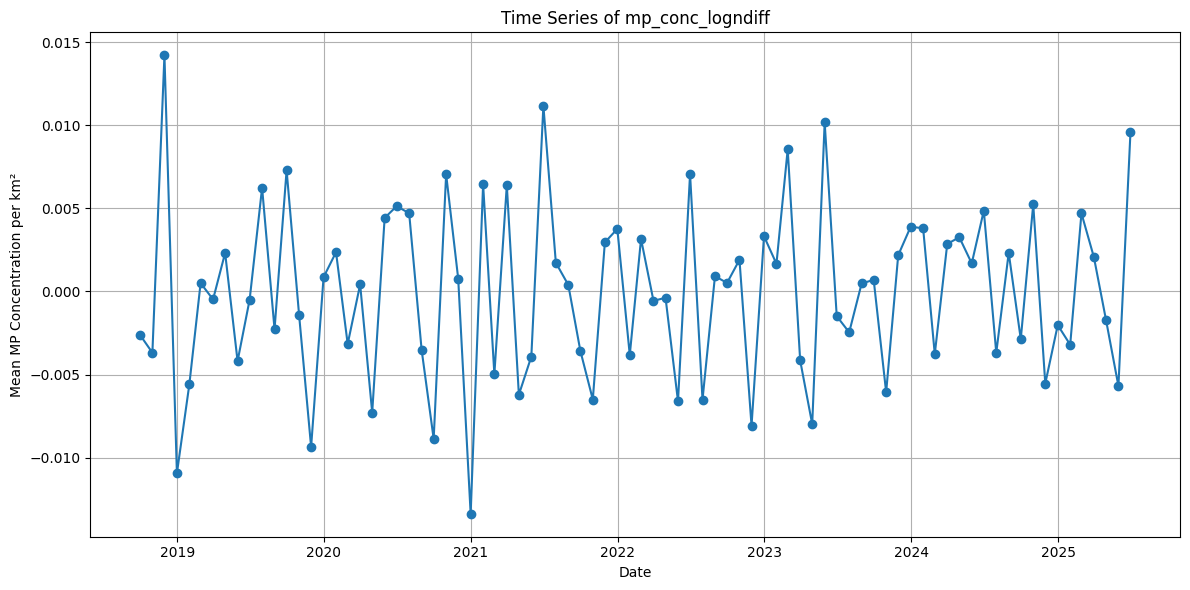

ADF Statistic:  -8.302102351322452
p-value:  3.9927819560925004e-13
Critical values: 
	1%: -3.52
	5%: -2.90
	10%: -2.59


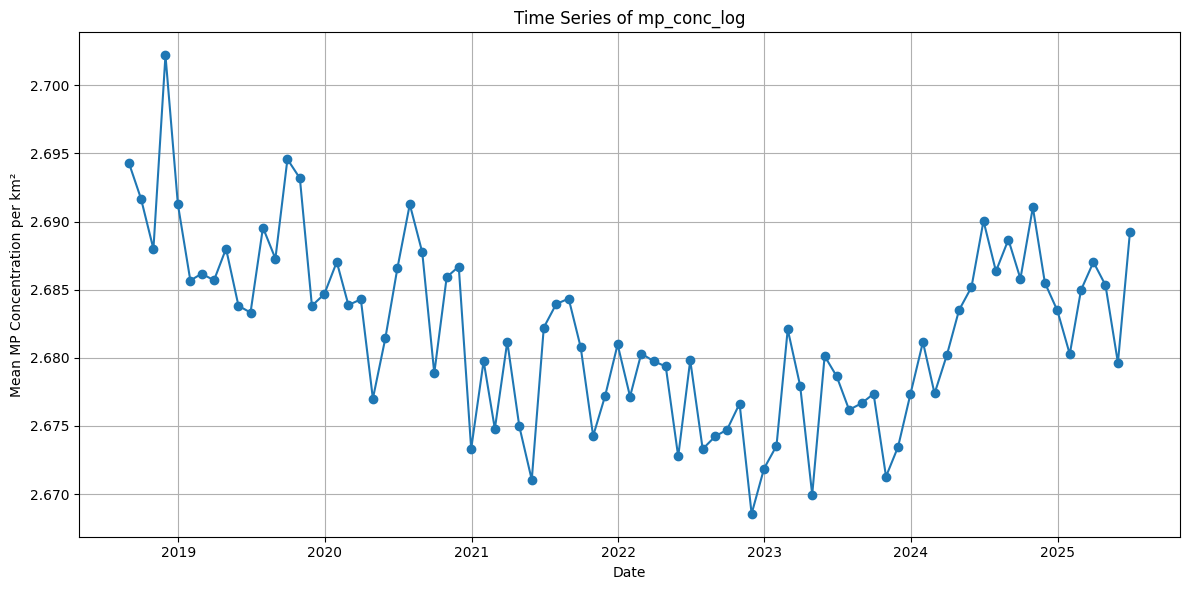

ADF Statistic:  -2.749149448824398
p-value:  0.06591252274030325
Critical values: 
	1%: -3.52
	5%: -2.90
	10%: -2.59


In [26]:
plot_graph(data, 'mp_conc_diff')
adf_test(data['mp_conc_diff'][1:])
plot_graph(data, 'mp_conc_logndiff')
adf_test(data['mp_conc_logndiff'][1:])
plot_graph(data, 'mp_conc_log')
adf_test(data['mp_conc_log'][:])





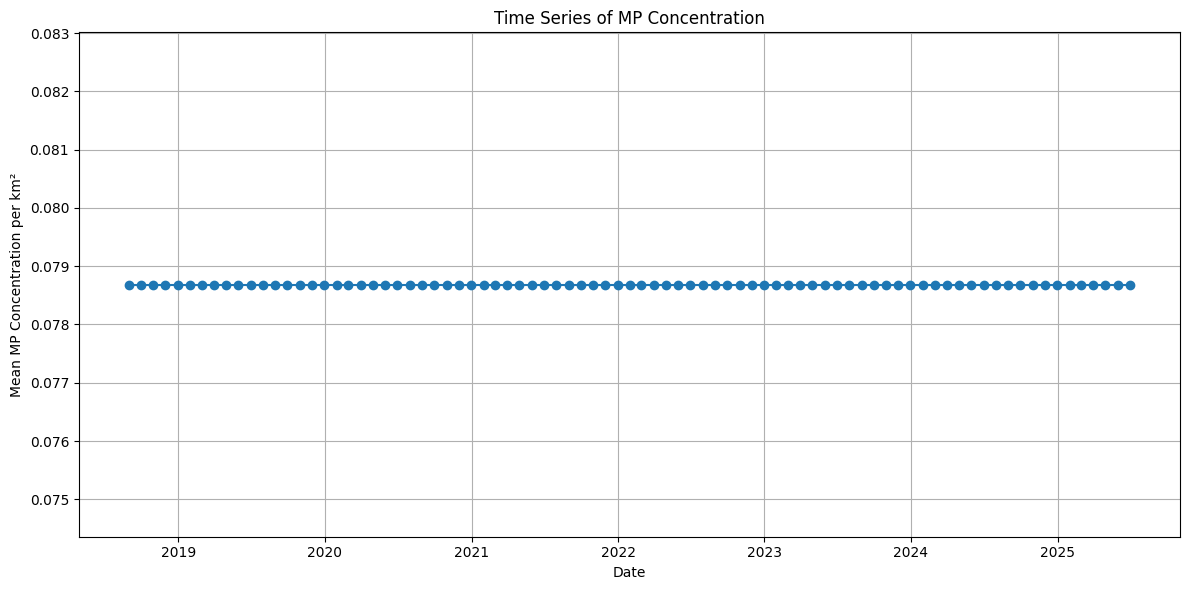

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['mp_conc_boxcox'], marker='o')
plt.xlabel('Date')
plt.ylabel('Mean MP Concentration per km²')
plt.title('Time Series of MP Concentration')
plt.grid(True)
plt.tight_layout()
plt.show()

The distribution itself is normal enough given the initial ADF test on microplastic data. All we need is to remove seasonality and perhaps assess the necesscity of doing logarithmic transform. 

## Decomposition

In [28]:
data = data.set_index('time')

KeyError: "None of ['time'] are in the columns"

In [13]:
data.dropna()

,mp_concentration,mp_conc_boxcox,mp_conc_diff,mp_conc_log,mp_conc_logndiff
time,,,,,
2018-09-30,14.756403,0.078685,-0.038549,2.691677,-0.002609
2018-10-31,14.702092,0.078685,-0.054311,2.687990,-0.003687
2018-11-30,14.912478,0.078685,0.210386,2.702198,0.014208
2018-12-31,14.750171,0.078685,-0.162306,2.691255,-0.010944
2019-01-31,14.667998,0.078685,-0.082174,2.685668,-0.005587
...,...,...,...,...,...
2025-02-28,14.657710,0.078685,0.068743,2.684966,0.004701
2025-03-31,14.687917,0.078685,0.030207,2.687025,0.002059
2025-04-30,14.663004,0.078685,-0.024913,2.685328,-0.001698


In [14]:
data.index = pd.to_datetime(data.index)
data

,mp_concentration,mp_conc_boxcox,mp_conc_diff,mp_conc_log,mp_conc_logndiff
time,,,,,
2018-08-31,14.794952,0.078685,NaN,2.694286,NaN
2018-09-30,14.756403,0.078685,-0.038549,2.691677,-0.002609
2018-10-31,14.702092,0.078685,-0.054311,2.687990,-0.003687
2018-11-30,14.912478,0.078685,0.210386,2.702198,0.014208
2018-12-31,14.750171,0.078685,-0.162306,2.691255,-0.010944
...,...,...,...,...,...
2025-02-28,14.657710,0.078685,0.068743,2.684966,0.004701
2025-03-31,14.687917,0.078685,0.030207,2.687025,0.002059
2025-04-30,14.663004,0.078685,-0.024913,2.685328,-0.001698


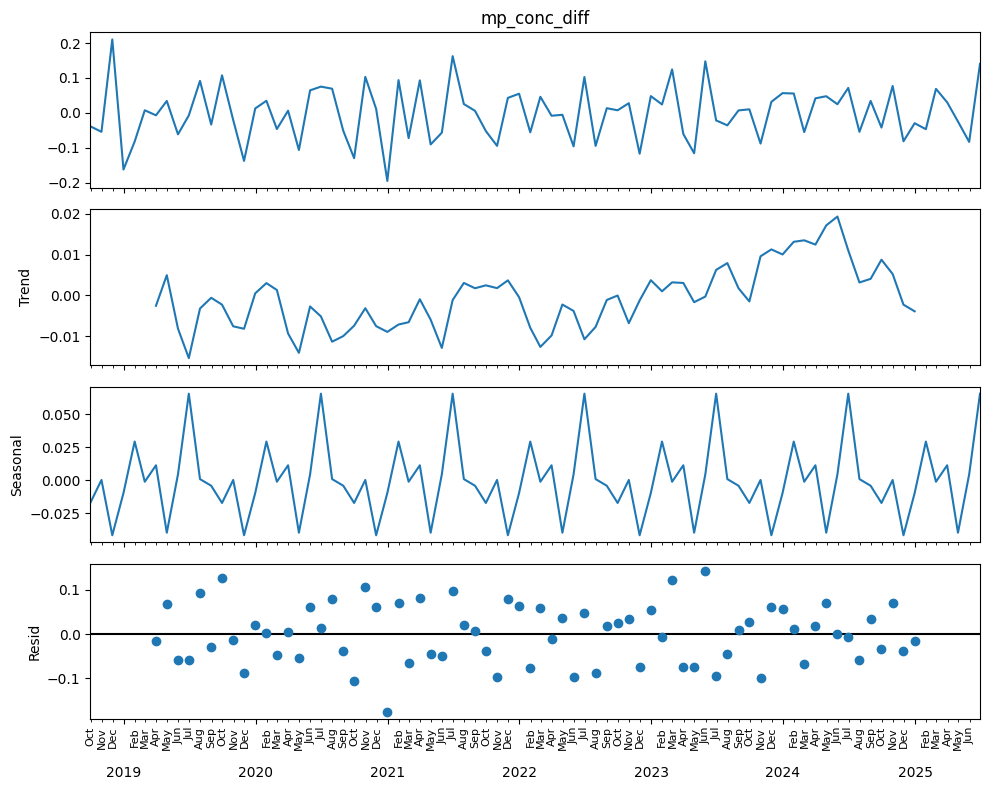

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

decomposition_plot_add = seasonal_decompose(data['mp_conc_diff'][1:],
                                            model='additive')
fig = decomposition_plot_add.plot()
fig.set_size_inches(10,8)

date_format = mdates.DateFormatter('%Y-%m') # Define the format: Year-Month

for ax in fig.axes:
    ax.xaxis.set_major_formatter(date_format)
    
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center") 

    ax.tick_params(axis='x', which='major', pad=30)

    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b')) 
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=90, fontsize=8) 

plt.tight_layout()
plt.show()


## ACF & PACF

In [43]:
data = data.dropna()
data

,mp_concentration,mp_conc_boxcox,mp_conc_diff,mp_conc_log,mp_conc_logndiff
time,,,,,
2018-09-30,14.756403,0.078685,-0.038549,2.691677,-0.002609
2018-10-31,14.702092,0.078685,-0.054311,2.687990,-0.003687
2018-11-30,14.912478,0.078685,0.210386,2.702198,0.014208
2018-12-31,14.750171,0.078685,-0.162306,2.691255,-0.010944
2019-01-31,14.667998,0.078685,-0.082174,2.685668,-0.005587
...,...,...,...,...,...
2025-02-28,14.657710,0.078685,0.068743,2.684966,0.004701
2025-03-31,14.687917,0.078685,0.030207,2.687025,0.002059
2025-04-30,14.663004,0.078685,-0.024913,2.685328,-0.001698


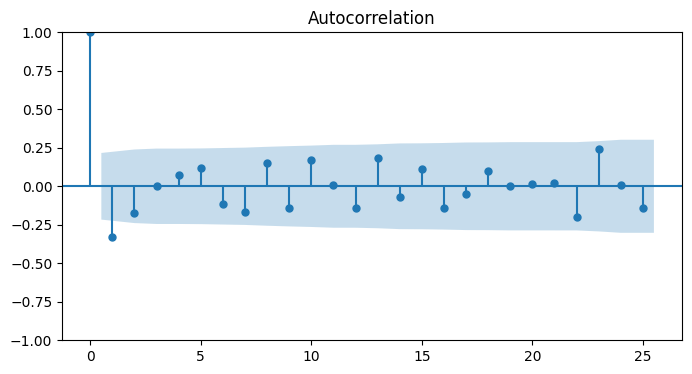

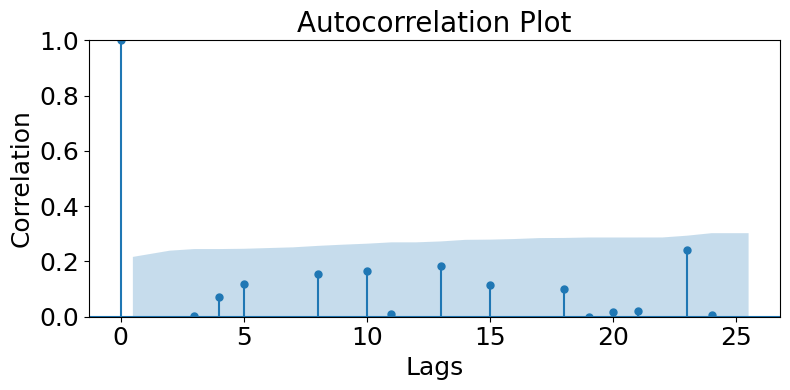

In [49]:
from statsmodels.graphics.tsaplots import plot_acf

plt.rc("figure", figsize=(8,4))
plot_acf(data['mp_conc_diff'], lags=25)
plot_acf(data['mp_conc_logndiff'], lags=25)
plt.ylim(0,1)
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Correlation', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Autocorrelation Plot', fontsize=20)
plt.tight_layout()
plt.show()

We observe the following: 
- There is a cyclical pattern in the lags every multiple of 7. 
- The blue region signifies the lags that are statistically significant. 

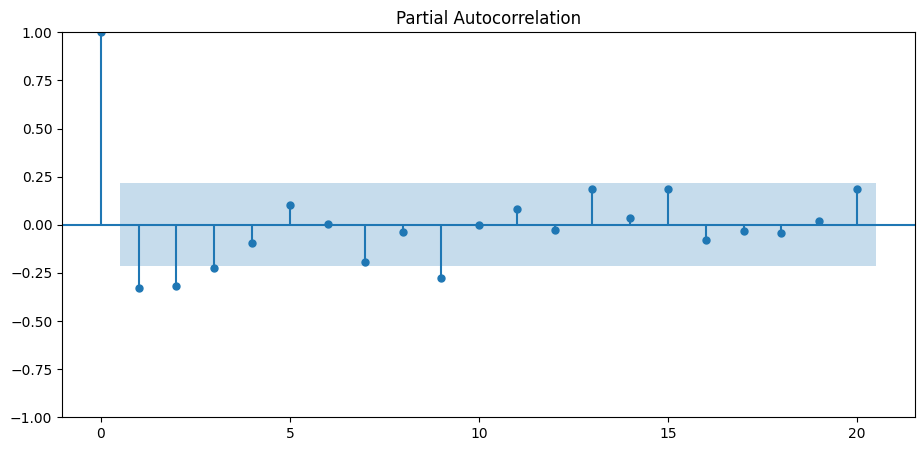

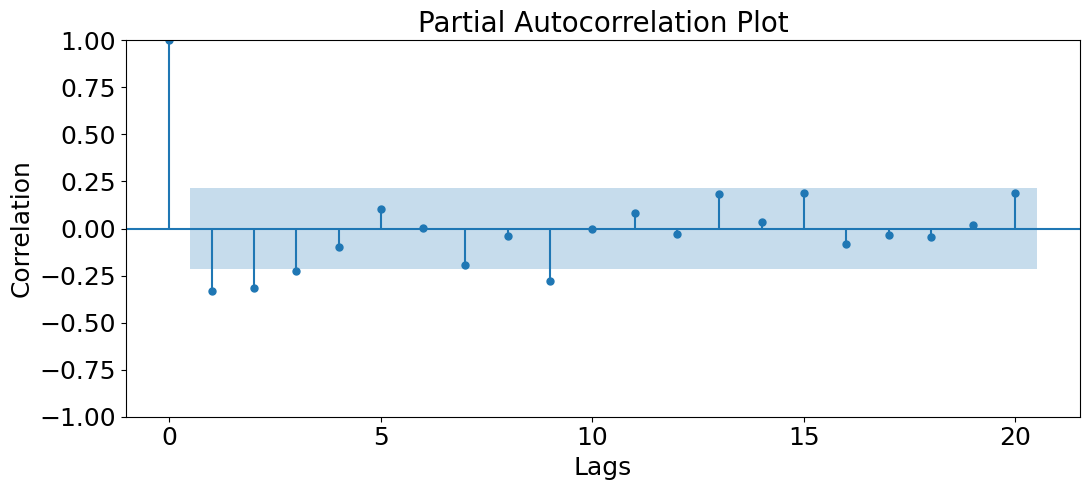

In [50]:
from statsmodels.graphics.tsaplots import plot_pacf
# Plot partial autocorrelation
plt.rc("figure", figsize=(11,5))
plot_pacf(data['mp_conc_diff'], method='ywm')
plot_pacf(data['mp_conc_logndiff'], method='ywm')
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Correlation', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Partial Autocorrelation Plot', fontsize=20)
plt.tight_layout()
plt.show()

Lag 1 is highly correlated. 
This shows the seasonal effect of about 6-7 months. 

## ARIMA

In [55]:
from statsmodels.tsa.arima.model import ARIMA

train = data.iloc[:-int(len(data) * 0.2)]
test = data.iloc[-int(len(data) * 0.2):]

model_1 = ARIMA(train['mp_concentration'], order=(1,1,9)).fit()
forecasts_1 = model_1.forecast(len(test))

model_2 = ARIMA(train['mp_concentration'], order=(2,1,9)).fit()
forecasts_2 = model_2.forecast(len(test))


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency ME will be used.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency ME will be used.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency ME will be used.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information

In [19]:
train, test

(            mp_concentration  mp_conc_boxcox  mp_conc_diff  mp_conc_log  \
 time                                                                      
 2018-08-31         14.794952        0.078685           NaN     2.694286   
 2018-09-30         14.756403        0.078685     -0.038549     2.691677   
 2018-10-31         14.702092        0.078685     -0.054311     2.687990   
 2018-11-30         14.912478        0.078685      0.210386     2.702198   
 2018-12-31         14.750171        0.078685     -0.162306     2.691255   
 ...                      ...             ...           ...          ...   
 2023-10-31         14.458527        0.078685     -0.088037     2.671284   
 2023-11-30         14.490066        0.078685      0.031539     2.673463   
 2023-12-31         14.546544        0.078685      0.056478     2.677353   
 2024-01-31         14.601951        0.078685      0.055407     2.681155   
 2024-02-29         14.546937        0.078685     -0.055013     2.677380   
 
          

In [56]:
import plotly.graph_objects as go
import nbformat

def plot_forecasts(forecasts_1: list[float], forecasts_2: list[float], title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train.index, y=train['mp_concentration'], name='Train'))
    fig.add_trace(go.Scatter(x=test.index, y=test['mp_concentration'], name='Test'))
    fig.add_trace(go.Scatter(x=test.index, y=forecasts_1, name='Forecast 1'))
    fig.add_trace(go.Scatter(x=test.index, y=forecasts_2, name='Forecast 2'))
    fig.update_layout(template="simple_white", font=dict(size=10), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Average Microplastic Concentration')

    return fig.show()


# Plot the forecasts
plot_forecasts(forecasts_1, forecasts_2, 'mp_concentration ARIMA')

## SARIMA

In [57]:
seasonal_1 = ARIMA(train['mp_concentration'], order=(1,1,9), seasonal_order=(1,1,1,12)).fit()
forecasts_1 = model_1.forecast(len(test))

model_2 = ARIMA(train['mp_concentration'], order=(2,1,9), seasonal_order=(1,1,1,12)).fit()
forecasts_2 = model_2.forecast(len(test))

plot_forecasts(forecasts_1, forecasts_2, 'mp_concentration ARIMA')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency ME will be used.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency ME will be used.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency ME will be used.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Li

## ARIMAX

You should consider upgrading via the '/usr/local/bin/python3.10 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
print(np.__version__)

1.26.4


In [4]:
import pmdarima as pm



In [9]:
# Read in the data
data = pd.read_csv('mp_conc_monthly.csv')
data['time'] = pd.to_datetime(data['time'])
data['month_num'] = data['time'].dt.month

# # Stabilise the variance
data.dropna()
data

,time,mp_concentration,month_num
0,2018-08-31,14.794952,8
1,2018-09-30,14.756403,9
2,2018-10-31,14.702092,10
3,2018-11-30,14.912478,11
4,2018-12-31,14.750171,12
...,...,...,...
78,2025-02-28,14.657710,2
79,2025-03-31,14.687917,3
80,2025-04-30,14.663004,4
81,2025-05-31,14.579799,5


In [10]:
# Get fourier features
for order in range(1, 10):
    data[f'fourier_sin_order_{order}'] = np.sin(2 * np.pi * order * data['month_num'] / 12)
    data[f'fourier_cos_order_{order}'] = np.cos(2 * np.pi * order * data['month_num'] / 12)

# name of fourier features
fourier_features = [i for i in list(data) if i.startswith('fourier')]

# Split train and test
train = data.iloc[:-int(len(data) * 0.2)]
test = data.iloc[-int(len(data) * 0.2):]

# Build auto-ARIMA model with fourier features
model = pm.auto_arima(train['mp_concentration'],
                      X=train[fourier_features],
                      seasonal=False,
                      stepwise=True,
                      suppress_warnings=True,
                      max_order=None,
                      information_criterion='aicc',
                      error_action="ignore")

# Get the forecasts and apply inverse box-cox transform
forecasts = model.predict(n_periods=len(test), X=test[fourier_features])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/pytho

In [13]:
import plotly.graph_objects as go
import nbformat

def plot_forecasts(forecasts: list[float], title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train.index, y=train['mp_concentration'], name='Train'))
    fig.add_trace(go.Scatter(x=test.index, y=test['mp_concentration'], name='Test'))
    fig.add_trace(go.Scatter(x=test.index, y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Passenger Volume')

    return fig.show()


# Plot the forecasts
plot_forecasts(forecasts, 'Harmonic Regression')